# 第6章 缺失数据

#### 在接下来的两章中，会接触到数据预处理中比较麻烦的类型，即缺失数据和文本数据（尤其是混杂型文本）
#### Pandas在步入1.0后，对数据类型也做出了新的尝试，尤其是Nullable类型和String类型，了解这些可能在未来成为主流的新特性是必要的

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/table_missing.csv')
df.head(10)

School Class      ID Gender   Address  Height  Weight  Math Physics
0    S_1   C_1     NaN      M  street_1     173     NaN  34.0      A+
1    S_1   C_1     NaN      F  street_2     192     NaN  32.5      B+
2    S_1   C_1  1103.0      M  street_2     186     NaN  87.2      B+
3    S_1   NaN     NaN      F  street_2     167    81.0  80.4     NaN
4    S_1   C_1  1105.0    NaN  street_4     159    64.0  84.8      A-
5    S_1   C_2  1201.0      M  street_5     159    68.0  97.0      A-
6    S_1   C_2  1202.0      F  street_4     176    94.0  63.5      B-
7    S_1   C_2     NaN      M  street_6     160    53.0  58.8      A+
8    S_1   C_2  1204.0      F  street_5     162    63.0  33.8     NaN
9    S_1   C_2  1205.0    NaN  street_6     167     NaN  68.4      B-

## 一、缺失观测及其类型

### 1. 了解缺失信息
#### （a）isna和notna方法
#### 对Series使用会返回布尔列表

In [2]:
df['Physics'].isna().head()

0    False
1    False
2    False
3     True
4    False
Name: Physics, dtype: bool

In [3]:
df['Physics'].notna().head()

0     True
1     True
2     True
3    False
4     True
Name: Physics, dtype: bool

#### 对DataFrame使用会返回布尔表

In [4]:
df.isna().head()

School  Class     ID  Gender  Address  Height  Weight   Math  Physics
0   False  False   True   False    False   False    True  False    False
1   False  False   True   False    False   False    True  False    False
2   False  False  False   False    False   False    True  False    False
3   False   True   True   False    False   False   False  False     True
4   False  False  False    True    False   False   False  False    False

#### 但对于DataFrame我们更关心到底每列有多少缺失值

In [5]:
df.isna().sum()

School      0
Class       4
ID          6
Gender      7
Address     0
Height      0
Weight     13
Math        5
Physics     4
dtype: int64

#### 此外，可以通过第1章中介绍的info函数查看缺失信息

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   School   35 non-null     object 
 1   Class    31 non-null     object 
 2   ID       29 non-null     float64
 3   Gender   28 non-null     object 
 4   Address  35 non-null     object 
 5   Height   35 non-null     int64  
 6   Weight   22 non-null     float64
 7   Math     30 non-null     float64
 8   Physics  31 non-null     object 
dtypes: float64(3), int64(1), object(5)
memory usage: 2.6+ KB


#### （b）查看缺失值的所以在行

#### 以最后一列为例，挑出该列缺失值的行

In [7]:
df[df['Physics'].isna()]

School Class      ID Gender   Address  Height  Weight  Math Physics
3     S_1   NaN     NaN      F  street_2     167    81.0  80.4     NaN
8     S_1   C_2  1204.0      F  street_5     162    63.0  33.8     NaN
13    S_1   C_3  1304.0    NaN  street_2     195    70.0  85.2     NaN
22    S_2   C_2  2203.0      M  street_4     155    91.0  73.8     NaN

#### （c）挑选出所有非缺失值列
#### 使用all就是全部非缺失值，如果是any就是至少有一个不是缺失值

In [8]:
df.notna().all(1).head(6)

0    False
1    False
2    False
3    False
4    False
5     True
dtype: bool

##### DataFrame.all(self, axis=0, bool_only=None, skipna=True, level=None, **kwargs)  
[pd.df.all](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.all.html)  
axis{0 or ‘index’, 1 or ‘columns’, None}, default 0  
indicate which axis or axes should be reduced.

* 0 / ‘index’ : reduce the index, return a Series whose index is the original column labels.

* 1 / ‘columns’ : reduce the columns, return a Series whose index is the original index.

* None : reduce all axes, return a scalar.

In [9]:
df[df.notna().all(1)]

School Class      ID Gender   Address  Height  Weight  Math Physics
5     S_1   C_2  1201.0      M  street_5     159    68.0  97.0      A-
6     S_1   C_2  1202.0      F  street_4     176    94.0  63.5      B-
12    S_1   C_3  1303.0      M  street_7     188    82.0  49.7       B
17    S_2   C_1  2103.0      M  street_4     157    61.0  52.5      B-
21    S_2   C_2  2202.0      F  street_7     194    77.0  68.5      B+
25    S_2   C_3  2301.0      F  street_4     157    78.0  72.3      B+
27    S_2   C_3  2303.0      F  street_7     190    99.0  65.9       C
28    S_2   C_3  2304.0      F  street_6     164    81.0  95.5      A-
29    S_2   C_3  2305.0      M  street_4     187    73.0  48.9       B

### 2. 三种缺失符号
#### （a）np.nan
#### np.nan是一个麻烦的东西，首先它不等与任何东西，甚至不等于自己

In [10]:
np.nan == np.nan

False

In [11]:
np.nan == 0

False

In [12]:
np.nan == None

False

#### 在用equals函数比较时，自动略过两侧全是np.nan的单元格，因此结果不会影响

In [13]:
df.equals(df)

True

#### 其次，它在numpy中的类型为浮点，由此导致数据集读入时，即使原来是整数的列，只要有缺失值就会变为浮点型

In [14]:
type(np.nan)

float

In [15]:
pd.Series([1,2,3]).dtype

dtype('int64')

In [16]:
pd.Series([1,np.nan,3]).dtype

dtype('float64')

#### 此外，对于布尔类型的列表，如果是np.nan填充，那么它的值会自动变为True而不是False

DataFrame.bool(self)  [pd.df.bool](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.bool.html)  
Return the bool of a single element PandasObject.  
This must be a boolean scalar value, either True or False.   
Raise a ValueError if the PandasObject does not have exactly 1 element, or that element is not boolean

* Returns bool
* Same single boolean value converted to bool type.
- 下面这一段内容，一开始粗心，以为是上面这一段，和助教一番battle后发现，不好意思粗心了。
- 我说所以为什么要Int64呢，难道有什么可以忽略大小写的后续能用吗？然后没有一个人理解我的意思，都在觉得我钻牛角尖，我当时就是生气，很生气。
- 然后助教 半解释了一堆我已经知道的，又说：大小写可能是为了区分pandas中的64位整型Int64和numpy中的64位整型int64，而numpy的int64对缺失值的支持不好。
- 行吧后面这部分还是有点东西，但是我没空（懒得)印证了

**dtypes**  [dtypes](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#basics-dtypes)
For the most part, pandas uses NumPy arrays and dtypes for Series or individual columns of a DataFrame.   
NumPy provides support for float, int, bool, timedelta64 and datetime64.
(note that NumPy does not support timezone-aware datetimes).
大概是pandas用的Numpy arrays and dtypes
**dtypes python**
[然后Numpy use python的，猜的，不会](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.dtypes.html)

In [17]:
# python中 bool为 False的, 其他均为True, 怀疑这里（pandas)和python是一样的
0  
0.0  
0j  # complex
False  
''    # 空字符串 
()    # 空元组
[]    # 空列表
set()  # 空集合
{}    # 空字典
None #系统关键字 代表什么也没有 ，一般用于初始化变量的时候用

In [18]:
pd.Series([1,np.nan,3],dtype='bool')

0    True
1    True
2    True
dtype: bool

#### 但当修改一个布尔列表时，会改变列表类型，而不是赋值为True

In [19]:
s = pd.Series([True,False],dtype='bool')
s[1]=np.nan
s

0    1.0
1    NaN
dtype: float64

#### 在所有的表格读取后，无论列是存放什么类型的数据，默认的缺失值全为np.nan类型
#### 因此整型列转为浮点；而字符由于无法转化为浮点，因此只能归并为object类型（'O'），原来是浮点型的则类型不变

In [20]:
df['ID'].dtype

dtype('float64')

In [21]:
df['Math'].dtype

dtype('float64')

In [22]:
df['Class'].dtype

dtype('O')

#### （b）None
#### None比前者稍微好些，至少它会等于自身

In [23]:
None == None

True

#### 它的布尔值为False

In [24]:
pd.Series([None],dtype='bool')

0    False
dtype: bool

#### 修改布尔列表不会改变数据类型

In [25]:
s = pd.Series([True,False],dtype='bool')
s[0]=None
s

0    False
1    False
dtype: bool

In [26]:
s = pd.Series([1,0],dtype='bool')
s[0]=None
s

0    False
1    False
dtype: bool

#### 在传入数值类型后，会自动变为np.nan

In [27]:
type(pd.Series([1,None])[1])

numpy.float64

#### 只有当传入object类型是保持不动，几乎可以认为，除非人工命名None，它基本不会自动出现在Pandas中

In [28]:
type(pd.Series([1,None],dtype='O')[1])

NoneType

####  在使用equals函数时不会被略过，因此下面的情况下返回False

In [29]:
pd.Series([None]).equals(pd.Series([np.nan]))

False

#### （c）NaT
#### NaT是针对时间序列的缺失值，是Pandas的内置类型，可以完全看做时序版本的np.nan，与自己不等，且使用equals是也会被跳过

In [30]:
s_time = pd.Series([pd.Timestamp('20120101')]*5)
s_time

0   2012-01-01
1   2012-01-01
2   2012-01-01
3   2012-01-01
4   2012-01-01
dtype: datetime64[ns]

In [31]:
s_time[2] = None
s_time

0   2012-01-01
1   2012-01-01
2          NaT
3   2012-01-01
4   2012-01-01
dtype: datetime64[ns]

In [32]:
s_time[2] = np.nan
s_time

0   2012-01-01
1   2012-01-01
2          NaT
3   2012-01-01
4   2012-01-01
dtype: datetime64[ns]

In [33]:
s_time[2] = pd.NaT
s_time

0   2012-01-01
1   2012-01-01
2          NaT
3   2012-01-01
4   2012-01-01
dtype: datetime64[ns]

In [34]:
type(s_time[2])

pandas._libs.tslibs.nattype.NaTType

In [35]:
s_time[2] == s_time[2]

False

In [36]:
s_time.equals(s_time)

True

In [37]:
s = pd.Series([True,False],dtype='bool')
s[1]=pd.NaT
s

0    True
1    True
dtype: bool

### 3. Nullable类型与NA符号
#### 这是Pandas在1.0新版本中引入的重大改变，其目的就是为了（在若干版本后）解决之前出现的混乱局面，统一缺失值处理方法
#### "The goal of pd.NA is provide a “missing” indicator that can be used consistently across data types (instead of np.nan, None or pd.NaT depending on the data type)."——User Guide for Pandas v-1.0
#### 官方鼓励用户使用新的数据类型和缺失类型pd.NA

#### （a）Nullable整形
#### 对于该种类型而言，它与原来标记int上的符号区别在于首字母大写：'Int'

In [38]:
s_original = pd.Series([1, 2], dtype="int64")
s_original

0    1
1    2
dtype: int64

In [157]:
s_new = pd.Series([1, 2], dtype="Int64")
s_new

0    1
1    2
dtype: Int64

#### 它的好处就在于，其中前面提到的三种缺失值都会被替换为统一的NA符号，且不改变数据类型

In [40]:
s_original[1] = np.nan
s_original

0    1.0
1    NaN
dtype: float64

In [158]:
s_new[1] = np.nan
s_new

0       1
1    <NA>
dtype: Int64

In [159]:
s_new.isna()

0    False
1     True
dtype: bool

In [42]:
s_new[1] = None
s_new

0       1
1    <NA>
dtype: Int64

In [43]:
s_new[1] = pd.NaT
s_new

0       1
1    <NA>
dtype: Int64

#### （b）Nullable布尔
#### 对于该种类型而言，作用与上面的类似，记号为boolean

In [44]:
s_original = pd.Series([1, 0], dtype="bool")
s_original

0     True
1    False
dtype: bool

In [45]:
s_new = pd.Series([0, 1], dtype="boolean")
s_new

0    False
1     True
dtype: boolean

In [46]:
s_original[0] = np.nan
s_original

0    NaN
1    0.0
dtype: float64

In [47]:
s_original = pd.Series([1, 0], dtype="bool") #此处重新加一句是因为前面赋值改变了bool类型
s_original[0] = None
s_original

0    False
1    False
dtype: bool

In [48]:
s_new[0] = np.nan
s_new

0    <NA>
1    True
dtype: boolean

In [49]:
s_new[0] = None
s_new

0    <NA>
1    True
dtype: boolean

In [50]:
s_new[0] = pd.NaT
s_new

0    <NA>
1    True
dtype: boolean

#### 需要注意的是，含有pd.NA的布尔列表在1.0.2之前的版本作为索引时会报错，这是一个之前的[bug](https://pandas.pydata.org/docs/whatsnew/v1.0.2.html#indexing-with-nullable-boolean-arrays)，现已经修复

In [51]:
s = pd.Series(['dog','cat'])
s[s_new]

1    cat
dtype: object

#### （c）string类型
#### 该类型是1.0的一大创新，目的之一就是为了区分开原本含糊不清的object类型，这里将简要地提及string，因为它是第7章的主题内容
#### 它本质上也属于Nullable类型，因为并不会因为含有缺失而改变类型

In [52]:
s = pd.Series(['dog','cat'],dtype='string')
s

0    dog
1    cat
dtype: string

In [53]:
s[0] = np.nan
s

0    <NA>
1     cat
dtype: string

In [54]:
s[0] = None
s

0    <NA>
1     cat
dtype: string

In [55]:
s[0] = pd.NaT
s

0    <NA>
1     cat
dtype: string

# ？？

#### 此外，和object类型的一点重要区别就在于，在调用字符方法后，string类型返回的是Nullable类型，object则会根据缺失类型和数据类型而改变

In [56]:
s = pd.Series(["a", None, "b"], dtype="string")
s.str.count('a')

0       1
1    <NA>
2       0
dtype: Int64

In [57]:
s2 = pd.Series(["a", None, "b"], dtype="object")
s2.str.count("a")

0    1.0
1    NaN
2    0.0
dtype: float64

In [58]:
s.str.isdigit()

0    False
1     <NA>
2    False
dtype: boolean

In [59]:
s2.str.isdigit()

0    False
1     None
2    False
dtype: object

### 4. NA的特性

#### （a）逻辑运算
#### 只需看该逻辑运算的结果是否依赖pd.NA的取值，如果依赖，则结果还是NA，如果不依赖，则直接计算结果

In [60]:
True | pd.NA

True

In [61]:
pd.NA | True

True

In [62]:
False | pd.NA

<NA>

In [63]:
False & pd.NA

False

In [64]:
True & pd.NA

<NA>

#### 取值不明直接报错

In [65]:
#bool(pd.NA)

#### （b）算术运算和比较运算
#### 这里只需记住除了下面两类情况，其他结果都是NA即可

In [66]:
pd.NA ** 0

1

In [67]:
1 ** pd.NA

1

#### 其他情况：

In [68]:
pd.NA + 1

<NA>

In [69]:
"a" * pd.NA

<NA>

In [70]:
pd.NA == pd.NA

<NA>

In [71]:
pd.NA < 2.5

<NA>

In [72]:
np.log(pd.NA)

<NA>

In [73]:
np.add(pd.NA, 1)

<NA>

### 5.  convert_dtypes方法
#### 这个函数的功能往往就是在读取数据时，就把数据列转为Nullable类型，是1.0的新函数

In [74]:
pd.read_csv('data/table_missing.csv').dtypes

School      object
Class       object
ID         float64
Gender      object
Address     object
Height       int64
Weight     float64
Math       float64
Physics     object
dtype: object

In [75]:
pd.read_csv('data/table_missing.csv').convert_dtypes().dtypes

School      string
Class       string
ID           Int64
Gender      string
Address     string
Height       Int64
Weight       Int64
Math       float64
Physics     string
dtype: object

## 二、缺失数据的运算与分组

### 1. 加号与乘号规则

#### 使用加法时，缺失值为0

In [76]:
s = pd.Series([2,3,np.nan,4])
s.sum()

9.0

#### 使用乘法时，缺失值为1

Series.prod(self, axis=None, skipna=None, level=None, numeric_only=None, min_count=0, **kwargs)  
[Series.prod](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.prod.html)  
Return the product of the values for the requested axis.

In [77]:
s.prod()

24.0

#### 使用累计函数时，缺失值自动略过

In [78]:
s.cumsum()

0    2.0
1    5.0
2    NaN
3    9.0
dtype: float64

In [79]:
s.cumprod()

0     2.0
1     6.0
2     NaN
3    24.0
dtype: float64

Series.pct_change(self: ~ FrameOrSeries, periods=1, fill_method='pad', limit=None, freq=None, **kwargs) → ~FrameOrSeries
[Series.pct_change](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.pct_change.html)  
Percentage change between the current and a prior element.  
Computes the percentage change from the immediately previous row by default.  
This is useful in comparing the percentage of change in a time series of elements.

In [80]:
s.pct_change()

0         NaN
1    0.500000
2    0.000000
3    0.333333
dtype: float64

### 2. groupby方法中的缺失值
#### 自动忽略为缺失值的组

In [81]:
df_g = pd.DataFrame({'one':['A','B','C','D',np.nan],'two':np.random.randn(5)})
df_g

one       two
0    A  1.660216
1    B  0.429846
2    C -0.061430
3    D -0.678914
4  NaN  2.050121

In [82]:
df_g.groupby('one').groups

{'A': Int64Index([0], dtype='int64'),
 'B': Int64Index([1], dtype='int64'),
 'C': Int64Index([2], dtype='int64'),
 'D': Int64Index([3], dtype='int64')}

## 三、填充与剔除

### 1. fillna方法

#### （a）值填充与前后向填充（分别与ffill方法和bfill方法等价）

In [83]:
df['Physics'].fillna('missing').head()

0         A+
1         B+
2         B+
3    missing
4         A-
Name: Physics, dtype: object

In [84]:
df['Physics'].fillna(method='ffill').head()

0    A+
1    B+
2    B+
3    B+
4    A-
Name: Physics, dtype: object

In [85]:
df['Physics'].fillna(method='backfill').head()

0    A+
1    B+
2    B+
3    A-
4    A-
Name: Physics, dtype: object

#### （b）填充中的对齐特性

In [86]:
df_f = pd.DataFrame({'A':[1,3,np.nan],'B':[2,4,np.nan],'C':[3,5,np.nan]})
df_f.fillna(df_f.mean())

A    B    C
0  1.0  2.0  3.0
1  3.0  4.0  5.0
2  2.0  3.0  4.0

#### 返回的结果中没有C，根据对齐特点不会被填充

In [87]:
df_f.fillna(df_f.mean()[['A','B']])

A    B    C
0  1.0  2.0  3.0
1  3.0  4.0  5.0
2  2.0  3.0  NaN

### 2. dropna方法

#### （a）axis参数

DataFrame.dropna(self, axis=0, how='any', thresh=None, subset=None, inplace=False)  
[df.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)  
axis{0 or ‘index’, 1 or ‘columns’}, default 0  
Determine if rows or columns which contain missing values are removed.

- 0, or ‘index’ : Drop rows which contain missing values.

- 1, or ‘columns’ : Drop columns which contain missing value.

- Changed in version 1.0.0: Pass tuple or list to drop on multiple axes. Only a single axis is allowed.

In [88]:
df_d = pd.DataFrame({'A':[np.nan,np.nan,np.nan],'B':[np.nan,3,2],'C':[3,2,1]})
df_d

A    B  C
0 NaN  NaN  3
1 NaN  3.0  2
2 NaN  2.0  1

In [89]:
df_d.dropna(axis=0)

Empty DataFrame
Columns: [A, B, C]
Index: []

In [90]:
df_d.dropna(axis=1)

C
0  3
1  2
2  1

#### （b）how参数（可以选all或者any，表示全为缺失 去除  和  存在 缺失 去除）

In [91]:
df_d.dropna(axis=1,how='all')

B  C
0  NaN  3
1  3.0  2
2  2.0  1

#### （c）subset参数（即在某一组列范围中搜索缺失值）

In [92]:
df_d.dropna(axis=0,subset=['B','C'])

A    B  C
1 NaN  3.0  2
2 NaN  2.0  1

## 四、插值（interpolation）

### 1. 线性插值

#### （a）索引无关的线性插值
#### 默认状态下，interpolate会对缺失的值进行线性插值

In [93]:
s = pd.Series([1,10,15,-5,-2,np.nan,np.nan,28])
s

0     1.0
1    10.0
2    15.0
3    -5.0
4    -2.0
5     NaN
6     NaN
7    28.0
dtype: float64

In [94]:
s.interpolate()

0     1.0
1    10.0
2    15.0
3    -5.0
4    -2.0
5     8.0
6    18.0
7    28.0
dtype: float64

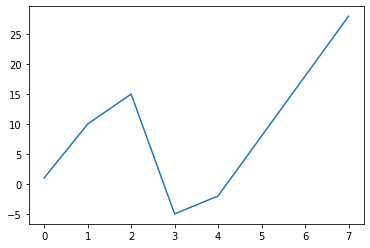

In [95]:
s.interpolate().plot()

#### 此时的插值与索引无关

In [96]:
s.index = np.sort(np.random.randint(50,300,8))
s.interpolate()
#值不变

54      1.0
108    10.0
149    15.0
178    -5.0
193    -2.0
223     8.0
238    18.0
288    28.0
dtype: float64

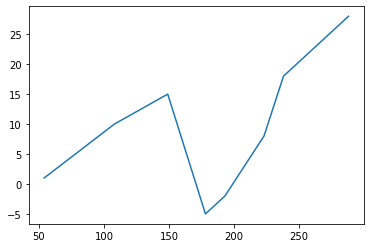

In [97]:
s.interpolate().plot()
#后面三个点不是线性的（如果几乎为线性函数，请重新运行上面的一个代码块，这是随机性导致的）

#### （b）与索引有关的插值
#### method中的index和time选项可以使插值线性地依赖索引，即插值为索引的线性函数

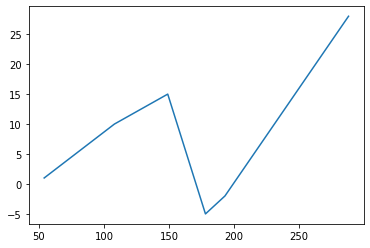

In [98]:
s.interpolate(method='index').plot()
#可以看到与上面的区别

#### 如果索引是时间，那么可以按照时间长短插值，对于时间序列将在第9章详细介绍

In [99]:
s_t = pd.Series([0,np.nan,10]
        ,index=[pd.Timestamp('2012-05-01'),pd.Timestamp('2012-05-07'),pd.Timestamp('2012-06-03')])
s_t

2012-05-01     0.0
2012-05-07     NaN
2012-06-03    10.0
dtype: float64

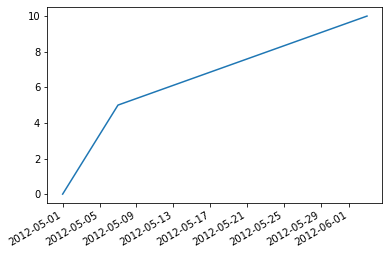

In [100]:
s_t.interpolate().plot()

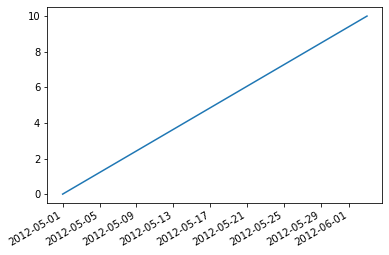

In [101]:
s_t.interpolate(method='time').plot()

### 2. 高级插值方法
#### 此处的高级指的是与线性插值相比较，例如样条插值、多项式插值、阿基玛插值等（需要安装Scipy），方法详情请看[这里](https://pandas.pydata.org/pandas-docs/version/1.0.0/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate)
#### 关于这部分仅给出一个官方的例子，因为插值方法是数值分析的内容，而不是Pandas中的基本知识：

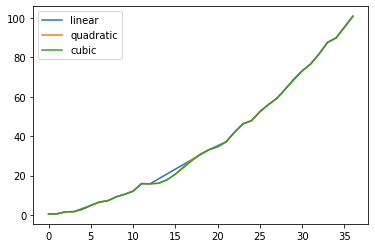

In [109]:
import scipy
import matplotlib.pyplot as plt
ser = pd.Series(np.arange(1, 10.1, .25) ** 2 + np.random.randn(37))
missing = np.array([4, 13, 14, 15, 16, 17, 18, 20, 29])
ser[missing] = np.nan
methods = ['linear', 'quadratic', 'cubic']
df = pd.DataFrame({m: ser.interpolate(method=m) for m in methods})
df.plot()
plt.show()

### 3. interpolate中的限制参数
#### （a）limit表示最多插入多少个

In [110]:
s = pd.Series([1,np.nan,np.nan,np.nan,5])
s.interpolate(limit=2)

0    1.0
1    2.0
2    3.0
3    NaN
4    5.0
dtype: float64

#### （b）limit_direction表示插值方向，可选forward,backward,both，默认前向

In [111]:
s = pd.Series([np.nan,np.nan,1,np.nan,np.nan,np.nan,5,np.nan,np.nan,])
s.interpolate(limit_direction='backward')

0    1.0
1    1.0
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    NaN
8    NaN
dtype: float64

#### （c）limit_area表示插值区域，可选inside,outside，默认None

In [112]:
s = pd.Series([np.nan,np.nan,1,np.nan,np.nan,np.nan,5,np.nan,np.nan,])
s.interpolate(limit_area='inside')

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    NaN
8    NaN
dtype: float64

In [113]:
s = pd.Series([np.nan,np.nan,1,np.nan,np.nan,np.nan,5,np.nan,np.nan,])
s.interpolate(limit_area='outside')

0    NaN
1    NaN
2    1.0
3    NaN
4    NaN
5    NaN
6    5.0
7    5.0
8    5.0
dtype: float64

## 五、问题与练习

### 1. 问题

#### 【问题一】 如何删除缺失值占比超过25%的列？



`data = data.isna().sum()/data.shape[0]>=0.25`

#### 【问题二】 什么是Nullable类型？请谈谈为什么要引入这个设计？
使用Nullable类型是一种统一处理缺失值的方法。所有的缺失类型都统一表示为pd.NA。  
避免了因为np.nan是float值，在使用缺失值的时候出现类型转换导致数据类型不统一难以处理的情况。

#### 【问题三】 对于一份有缺失值的数据，可以采取哪些策略或方法深化对它的了解？

1. 先使用　convert_dtypes　统一数据类型
2. 先检查看哪列有缺失值：　df.info()
3. 检查每列有多少缺失值：　df.isna().sum()
4. 检查某列缺失值所在行情况：　df[df['某列'].isna()]

### 2. 练习

#### 【练习一】现有一份虚拟数据集，列类型分别为string/浮点/整型，请解决如下问题：
#### （a）请以列类型读入数据，并选出C为缺失值的行。
#### （b）现需要将A中的部分单元转为缺失值，单元格中的最小转换概率为25%，且概率大小与所在行B列单元的值成正比。

设A中缺失值占比为prob，题目可以翻译成：
1. prob > 0.25
2. prob 正比 value in B

In [235]:
data = pd.read_csv('data/Missing_data_one.csv')
data

A      B     C
0   not_NaN  0.922   4.0
1   not_NaN  0.700   NaN
2   not_NaN  0.503   8.0
3   not_NaN  0.938   4.0
4   not_NaN  0.952  10.0
5   not_NaN  0.972   NaN
6   not_NaN  0.572   2.0
7   not_NaN  0.523  10.0
8   not_NaN  0.557  10.0
9   not_NaN  0.695   4.0
10  not_NaN  0.782   1.0
11  not_NaN  0.736   NaN
12  not_NaN  0.706   0.0
13  not_NaN  0.682   3.0
14  not_NaN  0.916   8.0
15  not_NaN  0.935   5.0
16  not_NaN  0.823   1.0
17  not_NaN  0.763   2.0
18  not_NaN  0.976   5.0
19  not_NaN  0.684   NaN
20  not_NaN  0.935   2.0
21  not_NaN  0.913   NaN
22  not_NaN  0.538   5.0
23  not_NaN  0.552   2.0
24  not_NaN  0.892   5.0
25  not_NaN  0.891   7.0
26  not_NaN  0.960   2.0
27  not_NaN  0.799   6.0
28  not_NaN  0.577   0.0
29  not_NaN  0.801   4.0

In [ ]:
data.info() # 如果按以前一般的做法，A的dtype是object

In [114]:
pd.read_csv('data/Missing_data_one.csv').head()

A      B     C
0  not_NaN  0.922   4.0
1  not_NaN  0.700   NaN
2  not_NaN  0.503   8.0
3  not_NaN  0.938   4.0
4  not_NaN  0.952  10.0

In [230]:
data['B'].max()

0.976

In [231]:
data['B'].max() / data['B'].min()

1.9403578528827037

In [189]:
# (a)
data=pd.read_csv('data/Missing_data_one.csv')
data.convert_dtypes().dtypes
data_c=data[data['C'].isna()]
data_c

A      B   C
1   not_NaN  0.700 NaN
5   not_NaN  0.972 NaN
11  not_NaN  0.736 NaN
19  not_NaN  0.684 NaN
21  not_NaN  0.913 NaN

In [224]:
data = pd.read_csv('data/Missing_data_one.csv').convert_dtypes().info()  # 现在用convert_dtypes 是string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       30 non-null     string 
 1   B       30 non-null     float64
 2   C       25 non-null     Int64  
dtypes: Int64(1), float64(1), string(1)
memory usage: 878.0 bytes


In [129]:
data_minb=data['B'].min()
data_minb

0.503

先来看看官方做法，首先他把A的values, B的values zip 成tuple,  
然后再转list 传给pd.Series

In [128]:
for (x, y) in zip(data['A'].values, data['B'].values):
    print (x, y)

not_NaN 0.922
not_NaN 0.7
not_NaN 0.503
not_NaN 0.938
not_NaN 0.9520000000000001
not_NaN 0.972
not_NaN 0.5720000000000001
not_NaN 0.523
not_NaN 0.557
not_NaN 0.695
not_NaN 0.782
not_NaN 0.736
not_NaN 0.706
not_NaN 0.682
not_NaN 0.9159999999999999
not_NaN 0.935
not_NaN 0.823
not_NaN 0.763
not_NaN 0.976
not_NaN 0.684
not_NaN 0.935
not_NaN 0.9129999999999999
not_NaN 0.5379999999999999
not_NaN 0.552
not_NaN 0.892
not_NaN 0.8909999999999999
not_NaN 0.96
not_NaN 0.799
not_NaN 0.5770000000000001
not_NaN 0.8009999999999999


In [161]:
test = pd.Series([(1,2),(3,5),(4,1)])
test

0    (1, 2)
1    (3, 5)
2    (4, 1)
dtype: object

In [149]:
test.apply(lambda x:x[0])
test

0    (1, 2)
1    (3, 2)
2    (4, 1)
dtype: object

他大概是说要么不变，  
什么时候不变呢就是 np.random.rand() > say0.26 (0.25*x[1]/data_minb) 的时候，  
其他时候就是np.nan。

可是这里其实有点问题，np.random.rand()是以给定的形状创建一个数组，并在数组中加入在[0,1]之间均匀分布的随机样本。  
也就是会取到<0.25, 此时照样进入条件 np.nan，  
?rand = np.random.rand() if np.random.rand()>0

In [226]:
a = np.random.rand()
a 

0.4143207522868412

In [228]:
"""def get_rand():
    if np.random.rand() > 0.25 :
        rand = np.random.rand()
    return rand
"""

'def get_rand():\n    if np.random.rand() > 0.25 :\n        rand = np.random.rand()\n    return rand\n'

In [221]:
# (b)
data=pd.read_csv('data/Missing_data_one.csv').convert_dtypes()
data_minb=data['B'].min()
data['A'] = pd.Series(list(zip(data['A'].values,data['B'].values))).apply(lambda x:x[0] if np.random.rand()>0.25*x[1]/data_minb else np.nan)

In [222]:
prob = data.isna().sum()/data.shape[0]
prob

A    0.200000
B    0.000000
C    0.166667
dtype: float64

#### 【练习二】 现有一份缺失的数据集，记录了36个人来自的地区、身高、体重、年龄和工资，请解决如下问题：
#### （a）统计各列缺失的比例并选出在后三列中至少有两个非缺失值的行。
#### （b）请结合身高列和地区列中的数据，对体重进行合理插值。

In [ ]:
pd.read_csv('data/Missing_data_two.csv').head()

In [ ]:
data=pd.read_csv('data/Missing_data_two.csv')
data.convert_dtypes().dtypes

In [ ]:
data.isna().sum()/data.shape[0]
data=data[data.iloc[:,-3:].isna().sum(1)<=1]
data

In [ ]:
df_method_1 = data.copy()
for name,group in df_method_1.groupby('地区'):
    df_method_1.loc[group.index,'体重'] = group[['身高','体重']].sort_values(by='身高').interpolate()['体重']
df_method_1['体重'] = df_method_1['体重'].round(decimals=2)
df_method_1.head()